In [1]:
import os
import pickle
import keras
import numpy as np
import sys
import argparse
import tensorflow as tf
import keras.backend as K

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Input, Activation, Conv2D, MaxPool2D, AveragePooling2D, Dropout, Flatten, Layer, ZeroPadding2D, Add, Lambda
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, Callback
from keras.backend.tensorflow_backend import set_session
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from cifar10 import CenterLossLayer, LSUVinit, CyclicLR

IMG_SHAPE = (32, 32, 3)
WEIGHT_DECAY = 1e-4
FEATURES_DIM = 128

Using TensorFlow backend.


In [2]:
# ARCHITECTURE 1: wide residual network

def expand_conv(init, base, k, stride):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    
    shortcut  = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(init)
    shortcut  = Activation('relu')(shortcut)
    
    x = Conv2D(base * k, (3, 3), strides=stride, padding='same', kernel_initializer='he_normal', use_bias=False)(shortcut)
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Conv2D(base * k, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    
    shortcut = Conv2D(base * k, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal', use_bias=False)(shortcut)
    m = Add()([x, shortcut])

    return m


def conv_block(input, n, stride, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Conv2D(n * k, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Conv2D(n * k, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', use_bias=False)(x)

    m = Add()([init, x])
    return m

def wide_residual_network(input_dim, nb_classes=10, N=2, k=1, dropout=0.0, optimizer = 'adam', summary = True):

    ip = Input(shape=input_dim)

    x = ZeroPadding2D((1, 1))(ip)
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    
    x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', use_bias=False)(x)

    nb_conv = 4

    x = expand_conv(x, 16, k, stride=(1,1))

    for i in range(N - 1):
        x = conv_block(x, n=16, stride=(1,1), k=k, dropout=dropout)
        nb_conv += 2

    x = expand_conv(x, 32, k, stride=(2,2))

    for i in range(N - 1):
        x = conv_block(x, n=32, stride=(2,2), k=k, dropout=dropout)
        nb_conv += 2

    x = expand_conv(x, 64, k, stride=(2,2))

    for i in range(N - 1):
        x = conv_block(x, n=64, stride=(2,2), k=k, dropout=dropout)
        nb_conv += 2

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, activation='softmax')(x)

    model = Model(ip, x)
    model.compile(loss='categorical_crossentropy',
                  optimizer = optimizer, metrics=['accuracy'])
    if summary:
        model.summary()
    return model

# sanety check
check_wrn = wide_residual_network((32, 32, 3), N = 5, k = 3, dropout= 0.5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 34, 16)   432         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 34, 34, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [3]:
# ARCHITECTURE 2: residual network
def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)

    return X


def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), 
                                kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides=(1, 1),
            padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides=(1, 1),
            padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s),
            padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resnet_like(input_shape=(32, 32, 3), classes=10, optimizer = 'adam'):
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (5, 5), strides=(2, 2),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPool2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(
        X, f=3, filters=[32, 32, 128], s=1)
    X = identity_block(X, 3, [32, 32, 128])
    X = identity_block(X, 3, [32, 32, 128])

    # Stage 3
    X = convolutional_block(
        X, f=3, filters=[64, 64, 256], s=2)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 4
    X = convolutional_block(
        X, f=3, filters=[128, 128, 512], s=1)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # # Stage 5
    # X = convolutional_block(
    #     X, f=3, filters=[256, 256, 1024], stage=5, block='a', s=2)
    # X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    # X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='my_resnet')
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    model.summary()
    return model

# sanety check
check_resnet = resnet_like()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 17, 17, 32)   2432        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 17, 17, 32)   128         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation

In [4]:
# ARCHITECTURE 3: simple softmax convolutional network

def conv_factory(input, filters, ksize, padding = 'same', pooling = None, pool_size = 2, activation = 'relu', dropout = 0.5):

    def frac_max_pool(x):
        return tf.nn.fractional_max_pool(x, [1.0, 1.44, 1.44, 1.0])[0]

    inner = Conv2D(filters, kernel_size = ksize, padding = padding, kernel_regularizer = l2(WEIGHT_DECAY))(input)
    if pooling == 'mp':
        inner = MaxPool2D(pool_size = pool_size, strides = 2)(inner)
    elif pooling == 'fmp':
        inner = Lambda(frac_max_pool)(inner)
    elif pooling == 'conv':
        inner = Conv2D(filters, kernel_size = 2, strides = 2, padding = 'valid', kernel_regularizer = l2(WEIGHT_DECAY))(inner)

    inner = Activation(activation=activation)(inner)
    inner = BatchNormalization()(inner)
    inner = Dropout(dropout)(inner)
    return inner


def base_model(activation='elu', summary=True, optimizer='adam', width = 32, depth = 3, pooling = 'mp'):
    inp = Input(shape=(IMG_SHAPE))
    inner = conv_factory(inp, width, 5, pooling=None,
                         activation=activation, dropout=0.2) #kernel_size 3->5
    inner = conv_factory(inner, width, 5, pooling=pooling,
                         activation=activation, dropout=0.2)  # kernel_size 3->5

    for d in range(depth):
        inner = conv_factory(inner, width*2**(d+1), 3, pooling=None,
                            activation=activation, dropout=0.2+ 0.1*(d+1) )
        inner = conv_factory(inner, width*2**(d+1), 3, pooling=pooling,
                            activation=activation, dropout=0.2+ 0.1*(d+1) )

    embedding = Flatten(name='embedding')(inner)
    # out = Dense(2048, activation=activation)(embedding)
    # out = Dropout(rate=0.5)(out)
    out = Dense(10, name='output')(embedding)
    out = Activation(activation='softmax')(out)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    if summary:
        model.summary()
    return model

def cnn_fmp(activation='elu', summary=True, optimizer='adam', width = 32, depth = 5):
    inp = Input(shape=(IMG_SHAPE))
    inner = conv_factory(inp, 32, 5, pooling=None,
                         activation=activation, dropout=0.25) #kernel_size 3->5

    for d in range(depth):
        inner = conv_factory(inner, width * 2 ** (d+1), 5, pooling='fmp',
                            activation=activation, dropout=0.5) #kernel_size 3->5

    embedding = Flatten(name='embedding')(inner)
    # out = Dense(1024, activation=activation)(embedding)
    # out = Dropout(rate=0.5)(out)
    out = Dense(10, name='output')(embedding)
    out = Activation(activation='softmax')(out)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    if summary:
        model.summary()
    return model

# sanety check
check_base = base_model(depth = 2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_62 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [5]:
# miscellaneous

def load_data(normalize = True):
    print("Loading data ...")
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=97)
    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    y_valid = keras.utils.to_categorical(y_valid)
    if normalize:
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train,axis=(0,1,2,3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        X_valid = (X_valid-mean)/(std+1e-7)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

def load_weights(model, name):
    print("Loading weights ...")
    if os.path.isfile("{}.h5".format(name)):
        model.load_weights("{}.h5".format(name))
    else:
        print("No pretrained weights")

def schedule(epoch):
    lrate = 0.01
    if epoch > 75:
        lrate = 0.005
    elif epoch > 100:
        lrate = 0.0005
    return lrate

def save_history(history, model_name):
    import matplotlib.pyplot as plt
    print("Saving training history ...")
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['acc']
    val_acc = history['val_acc']
    
    plt.figure()
    plt.subplot(121)
    plt.xlabel("Ep")
    plt.ylabel("Loss")
    plt.plot(np.arange(len(loss)), loss, c = 'C0', label = 'loss')
    plt.plot(np.arange(len(val_loss)), val_loss, c = 'C1', label = 'val_loss')
    plt.legend()

    plt.subplot(122)
    plt.xlabel("Ep")
    plt.ylabel("Acc")
    plt.plot(np.arange(len(acc)), acc, c = 'C0', label = 'acc')
    plt.plot(np.arange(len(val_acc)), val_acc, c = 'C1', label = 'val_acc')
    plt.legend()

    plt.savefig(model_name)

def eval(X, y, mode, model):
    score = model.evaluate(X, y, batch_size=32, verbose=1)
    print("{} accuracy: {}%".format(mode, score[1]*100))

In [6]:
def custom_model(model_type, depth = 0, wide = 0, pooling = 'mp'):
    opt = RMSprop(lr=0.001, decay=1e-6)
    if model_type == 'wrn':
        model = wide_residual_network(
            IMG_SHAPE, 10, depth, width, 0.5, optimizer=opt)
    elif model_type == 'base':
        model = base_model(optimizer=opt, width=width, depth=depth, pooling=pooling)
    elif model_type == 'fmp':
        model = cnn_fmp(optimizer=opt, width=width, depth=depth)
    elif model_type == 'resnet':
        model = resnet_like(IMG_SHAPE, 10, optimizer=opt)
    
    return model

In [7]:
def main(model, epochs = 200, batch_size = 32, use_cyclic = False, lsuv_init = False, augment = True, normalize = True, load_weights = False, model_name = 'best_weights'):
    X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(normalize)

    print('Training data shape: ', X_train.shape)
    print('Training labels shape: ', y_train.shape)
    print('Validation data shape: ', X_valid.shape)
    print('Validation labels shape: ', y_valid.shape)
    print('Test data shape: ', X_test.shape)
    print('Test labels shape: ', y_test.shape)

    print("Building model ...")
    early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
    
    if use_cyclic:
        print("*using cyclical lr")
        lr_schedule = CyclicLR(base_lr=0.001, max_lr=0.006,
                               step_size=2000., mode='exp_range',
                               gamma=0.99994)
    else:
        lr_schedule = LearningRateScheduler(schedule)
    
    if lsuv_init:
        model = LSUVinit(model, X_train[:128])
        
    if load_weights:
        load_weights(model, model_name)
        
            
    print("Start training ...")
    if augment:
        datagen = ImageDataGenerator(
                                    featurewise_center=False,  # set input mean to 0 over the dataset
                                    samplewise_center=False,  # set each sample mean to 0
                                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                    samplewise_std_normalization=False,  # divide each input by its std
                                    zca_whitening=False,  # apply ZCA whitening
                                    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                                    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                    horizontal_flip=True,  # randomly flip images
                                    vertical_flip=False)  # randomly flip images
        datagen.fit(X_train)
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                                        steps_per_epoch = X_train.shape[0] // batch_size, epochs= epochs,\
                                        verbose=1, validation_data=(X_valid, y_valid), callbacks=[early_stop, lr_schedule])
    else:
        history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs,
                            batch_size=batch_size, verbose=1, callbacks=[early_stop, lr_schedule])

    save_history(history.history, model_name)

In [8]:
def evaluate(model_name, model = None, normalize =1, mode = 'all'):
    print("Evaluating ...")
    X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(normalize)
    load_weights(model, model_name)
    
    if mode == 'all':
        eval(X_train, y_train, 'train', model)
        eval(X_valid, y_valid, 'valid', model)
        eval(X_test, y_test, 'test', model)
    elif mode == 'train':
        eval(X_train, y_train, 'train', model)
        eval(X_valid, y_valid, 'valid', model)
    elif mode == 'test':
        eval(X_test, y_test, 'test', model)


In [ ]:
model = base_model()
main(model, use_cyclic=True)

In [9]:
# experiment results
images = [im for im in os.listdir(".") if 'png' in im]
images

['base_mp_3_32_1_1_1_1_0.png',
 'base_mp_3_32_1_1_1_0_0.png',
 'base_mp_2_32_1_1_1_1_0.png',
 'base_mp_2_32_1_1_1_0_0.png',
 'wrn_2_2_1_1_0_0_0.png',
 'base_mp_2_32_1_1_0_0_0.png',
 'wrn_4_5_1_1_1_1_0.png',
 'base_conv_2_32_1_1_0_0_0.png',
 'base_conv_3_32_1_1_1_1_0.png']

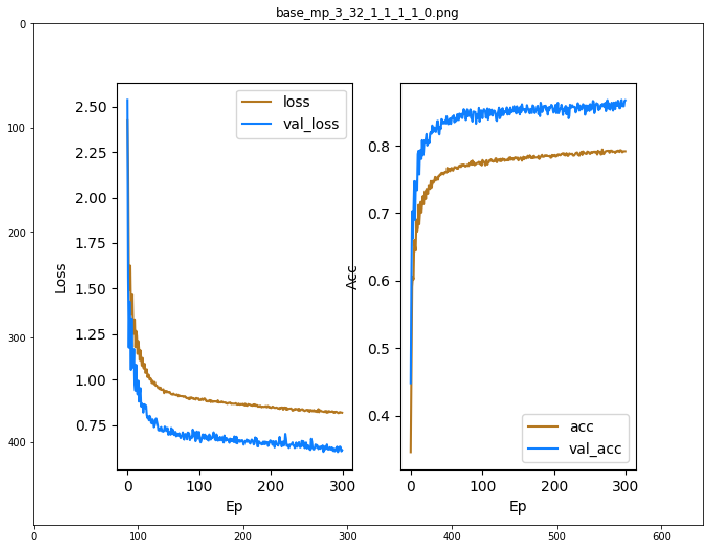

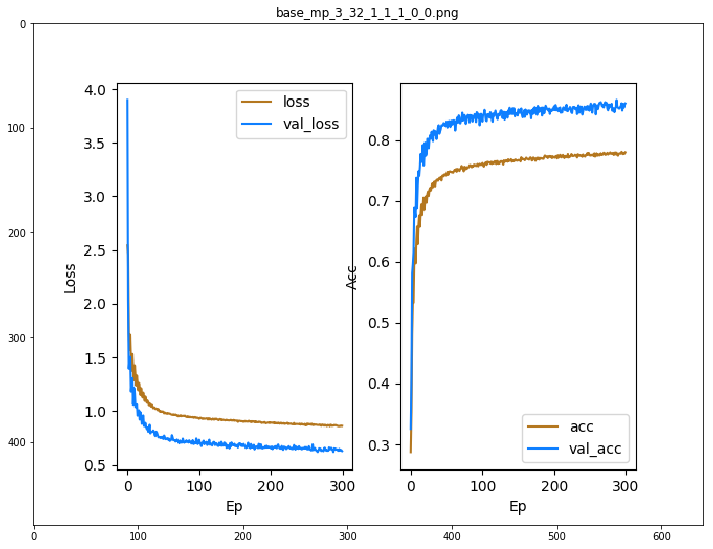

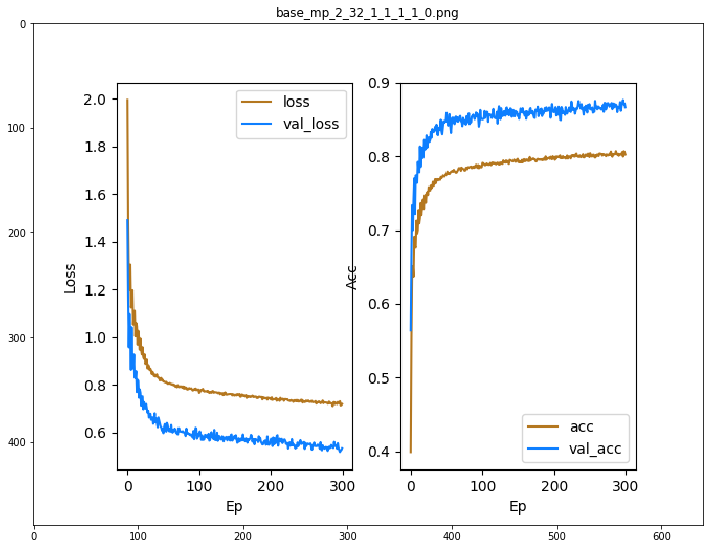

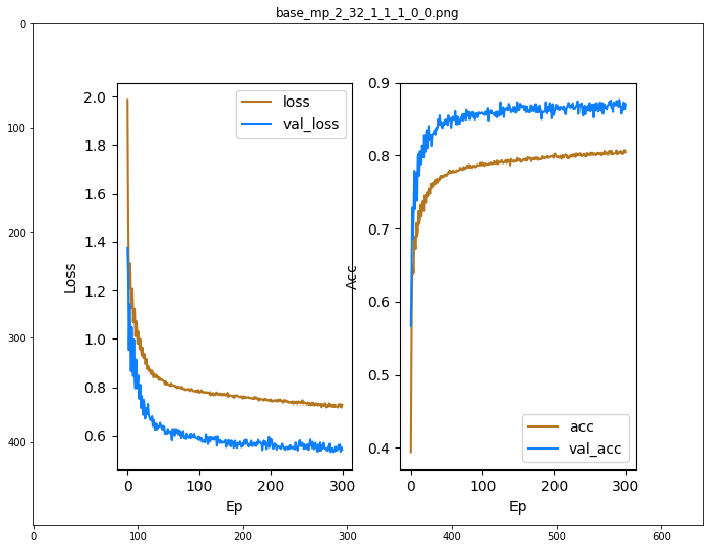

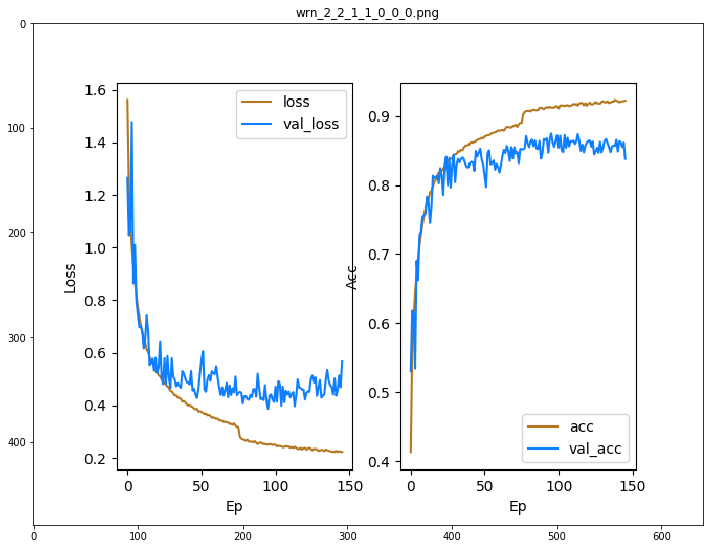

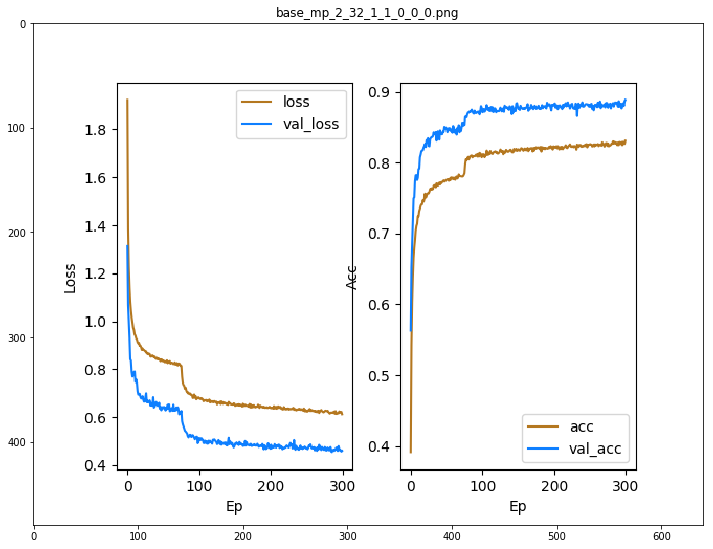

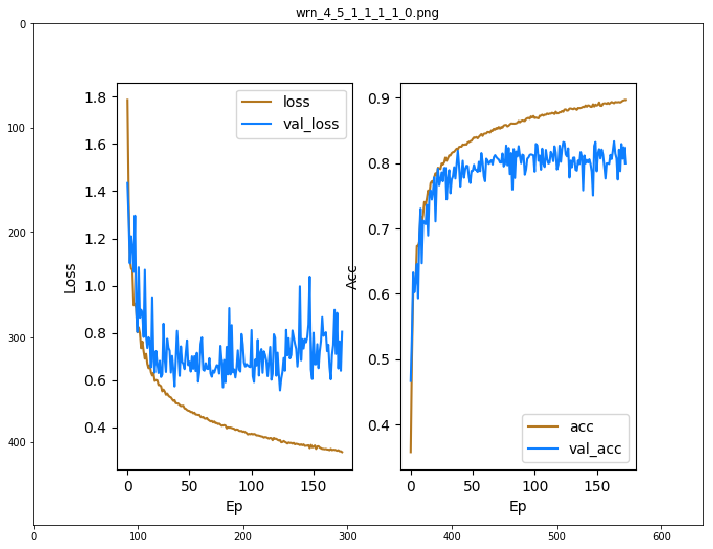

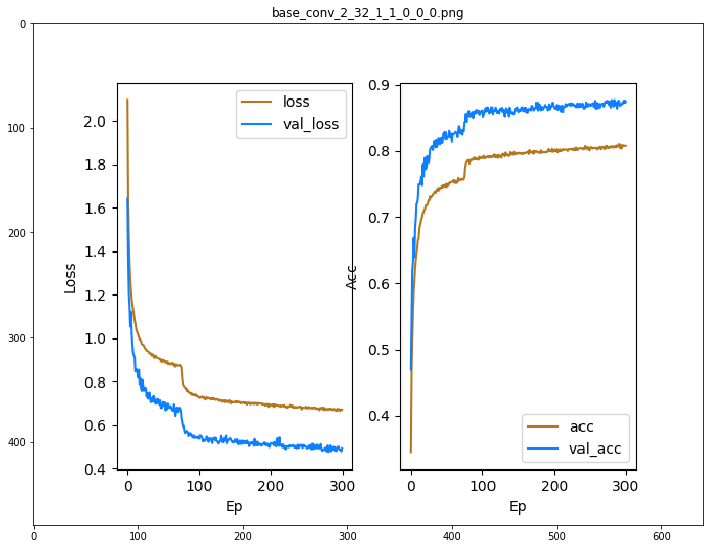

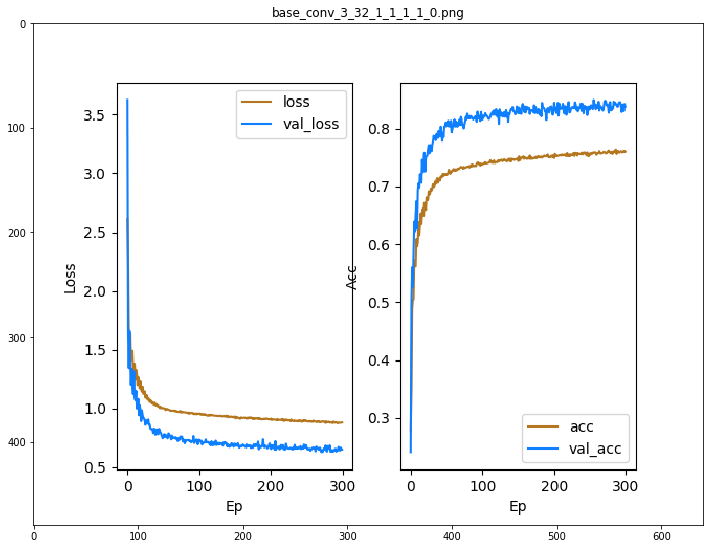

In [10]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline
for im in images:
    img = cv2.imread(im)
    plt.figure(figsize=(12, 12))
    plt.title(im)
    plt.imshow(img)
    plt.show()

In [12]:
# best model 
best_model = base_model(depth=2)
evaluate("base_mp_2_32_1_1_0_0_0", best_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_76 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [14]:
# using different learning rate and initialization strategy
evaluate("base_mp_2_32_1_1_1_0_0", best_model, mode = 'test') # cyclic learning rate, earlier convergence but somtimes better accuracy
evaluate("base_mp_2_32_1_1_1_1_0", best_model, mode = 'test') # lsuv init, good reputation but seems to be not good in this architecture

Evaluating ...
Loading data ...
Loading weights ...
10000/10000 [==============================] - 10s 1ms/step
test accuracy: 86.32%


In [15]:
# how about making it deeper
model = base_model(depth=3)
evaluate("base_mp_3_32_1_1_1_0_0", model, mode ='test') # deepening the network is not always better :<

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_83 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
__________

In [16]:
# how about making it fully convolutional
model = base_model(depth=2, pooling = 'conv')
evaluate("base_conv_2_32_1_1_0_0_0", model, mode = 'test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_92 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_39 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 32)        25632     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 32)        4128      
__________

In [18]:
# how about different architecture, here comes residual net and wide residual net, I deleted resnet weights by accident :<
model = wide_residual_network((32,32,3), N = 2, k =2)
evaluate("wrn_2_2_1_1_0_0_0", model, mode = 'test') # the paper says that with somewhat large N and k the test accuracy can be up to 92%

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 34, 34, 3)    0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 34, 34, 16)   432         zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
batch_normalization_97 (BatchNo (None, 34, 34, 16)   64          conv2d_104[0][0]                 
__________________________________________________________________________________________________
activation

Loading weights ...
10000/10000 [==============================] - 28s 3ms/step
test accuracy: 87.01%
